# DREAM5 - SGBM benchmark

In [1]:
import os
import sys
sys.path.append('../../')

from arboreto.core import *
from arboreto.utils import *

import matplotlib.pyplot as plt

## Data paths

In [2]:
wd = os.getcwd().split('arboreto')[0] + 'arboreto/resources/dream5/'

net1_ex_path = wd + 'net1/net1_expression_data.tsv'
net1_tf_path = wd + 'net1/net1_transcription_factors.tsv'

net3_ex_path = wd + 'net3/net3_expression_data.tsv'
net3_tf_path = wd + 'net3/net3_transcription_factors.tsv'

net4_ex_path = wd + 'net4/net4_expression_data.tsv'
net4_tf_path = wd + 'net4/net4_transcription_factors.tsv'

## Dask client

In [3]:
from dask.distributed import Client, LocalCluster

In [4]:
client = Client(LocalCluster())

In [5]:
client

Client Scheduler: tcp://127.0.0.1:44885 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 88 Cores: 88 Memory: 135.07 GB


Use port forwarding to view the dashboard `$ ssh -L 8000:localhost:8787 nostromo`

In [6]:
# client.shutdown()

## Infer networks (with meta)

In [6]:
def infer_network_and_meta(ex_path, tf_path, client):
    ex_matrix = load_expression_matrix(ex_path)
    gene_names = load_gene_names(ex_path)
    tf_names = load_tf_names(tf_path, gene_names)
    
    network_graph, meta_graph = create_graph(ex_matrix,
                                             gene_names,
                                             tf_names,
                                             "GBM",
                                             SGBM_KWARGS,
                                             client=client,
                                             'all',
                                             early_stop_window_length=25,
                                             include_meta=True)
    
    # Good!
    a, b = client.persist([network_graph, meta_graph])
    network_df = a.compute(sync=True)
    meta_df = b.compute(sync=True)
    
    return network_df, meta_df

In [7]:
%%time
net1, meta1 = infer_network_and_meta(net1_ex_path, net1_tf_path, client)

NameError: name 'load_expression_matrix' is not defined

In [11]:
%%time
net3, meta3 = infer_network_and_meta(net3_ex_path, net3_tf_path, client)

CPU times: user 2min 10s, sys: 1min 1s, total: 3min 11s
Wall time: 3min 52s


In [12]:
%%time
net4, meta4 = infer_network_and_meta(net4_ex_path, net4_tf_path, client)

CPU times: user 2min 24s, sys: 1min 1s, total: 3min 26s
Wall time: 3min 57s


In [25]:
def write_top(df_links, out_path, n=100000):
    """
    Write the links to the specified output path.
    """
    df_links.nlargest(n, columns=['importance']).to_csv(out_path, index=False, header=False, sep='\t')

## Plotting top importance by nr of boosting rounds

In [18]:
def scatter_top_importance_by_rounds(net, meta, n=1):
    meta.merge(net.groupby(['target'])['importance'].nlargest(n).reset_index(), 
               how='left', 
               on=['target']).plot.scatter(x='n_estimators', 
                                           y='importance', 
                                           figsize=(16, 9))
    plt.show()

In [19]:
def hexbin_top_importance_by_rounds(net, meta, n=1):
    meta.merge(net.groupby(['target'])['importance'].nlargest(n).reset_index(), 
               how='left', 
               on=['target']).plot.hexbin(x='n_estimators', 
                                          y='importance',   
                                          bins='log',
                                          cmap=plt.get_cmap("inferno"),
                                          figsize=(16, 9))
    plt.show()

In [17]:
net4.nlargest(100000, columns=['importance']).head()

,TF,target,importance
37,G38,G243,141.018922
140,G141,G2710,139.493231
241,G243,G38,123.243948
287,G288,G1082,116.486176
114,G115,G729,105.002217


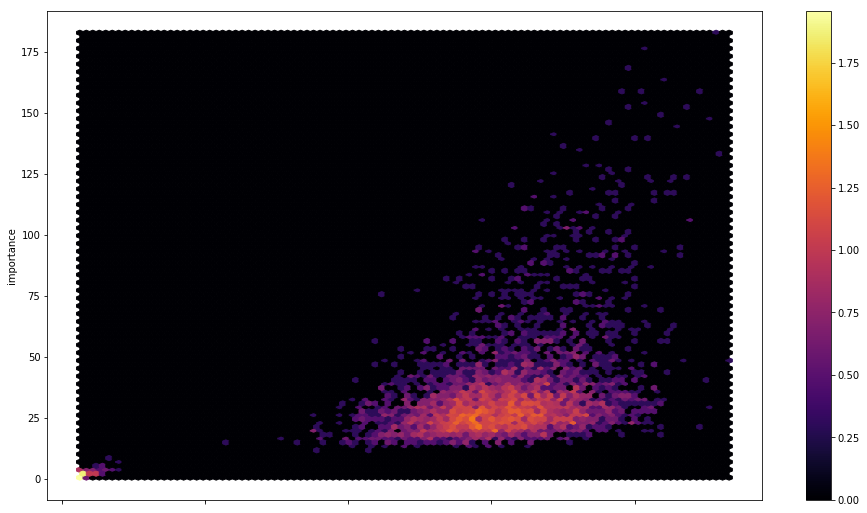

In [23]:
hexbin_top_importance_by_rounds(net3, meta3)

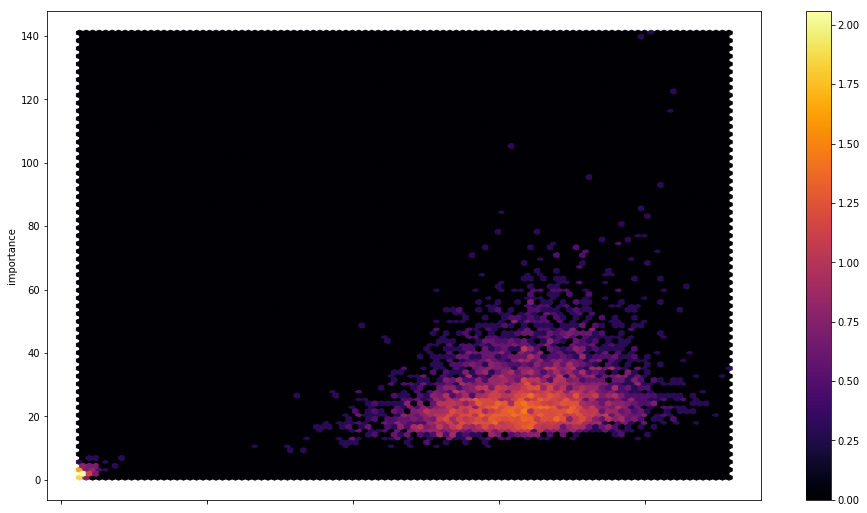

In [24]:
hexbin_top_importance_by_rounds(net4, meta4)

In [26]:
write_top(net1, 'net1.tsv')

In [28]:
write_top(net3, 'net3.tsv')

In [27]:
write_top(net4, 'net4.tsv')

## DREAM5 benchmark evaluation

In [12]:
eval_df = pd.read_csv('eval.sgbm.denorm.win.25.txt')

In [13]:
eval_df

,metric,GRNBoost,GENIE3
0,Overall Score,6.411590e+01,4.027898e+01
1,AUPR (pvalue),8.399037e+01,4.129532e+01
2,AUROC (pvalue),4.424144e+01,3.926265e+01
3,Net1 AUPR,3.558841e-01,2.909863e-01
4,Net3 AUPR,1.222214e-01,9.302545e-02
5,Net4 AUPR,2.299922e-02,2.065091e-02
6,Net1 AUROC,8.155145e-01,8.148355e-01
7,Net3 AUROC,6.335665e-01,6.170165e-01
8,Net4 AUROC,5.238476e-01,5.176411e-01
9,Net1 p-aupr,4.313612e-207,1.596591e-104


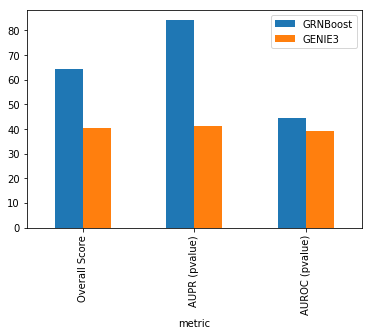

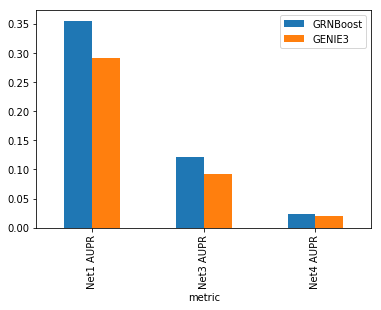

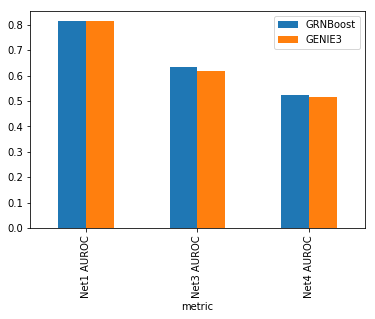

In [17]:
eval_df[:3].plot.bar(x='metric')
eval_df[3:6].plot.bar(x='metric')
eval_df[6:9].plot.bar(x='metric')
plt.show()